# **1. Data Cleaning**

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import  StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
import cloudpickle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_selection import SelectKBest, f_regression


In [4]:
#Load Datasets
train_path = "/content/drive/MyDrive/GUVI/Miniproject4/data/train_data.csv"
test_path  = "/content/drive/MyDrive/GUVI/Miniproject4/data/test_data.csv"

# Load with explicit dtype handling to avoid mixed types
train = pd.read_csv(train_path, low_memory=False)
test  = pd.read_csv(test_path, low_memory=False)

print(f"Train Shape: {train.shape}")
print(f"Test Shape:  {test.shape}")

# Quick sanity check
print("Train columns:", train.columns.tolist())
print("Test columns:", test.columns.tolist())

Train Shape: (132379, 14)
Test Shape:  (33095, 14)
Train columns: ['year', 'month', 'day', 'order', 'country', 'session_id', 'page1_main_category', 'page2_clothing_model', 'colour', 'location', 'model_photography', 'price', 'price_2', 'page']
Test columns: ['year', 'month', 'day', 'order', 'country', 'session_id', 'page1_main_category', 'page2_clothing_model', 'colour', 'location', 'model_photography', 'price', 'price_2', 'page']


In [5]:
# Handle Missing Values
# Fill numeric missing values with median (use train median for both train & test to avoid leakage)
for col in train.select_dtypes(include=[np.number]).columns:
    median_val = train[col].median()
    train[col].fillna(median_val, inplace=True)
    if col in test.columns:
        test[col].fillna(median_val, inplace=True)

# Fill categorical missing values with mode (use train mode for both train & test)
for col in train.select_dtypes(include=['object']).columns:
    mode_val = train[col].mode()[0]
    train[col].fillna(mode_val, inplace=True)
    if col in test.columns:
        test[col].fillna(mode_val, inplace=True)

# Check duplicates
print(f"Number of duplicate rows in train: {train.duplicated().sum()}")


Number of duplicate rows in train: 0


# **2.Feature Engineering**

In [6]:
for df in [train, test]:
    # Session-level metrics
    # Length of session = max order index
    df['session_length'] = df.groupby('session_id')['order'].transform('max')
    # Number of clicks in the session
    df['num_clicks'] = df.groupby('session_id')['order'].transform('count')
    # Time spent per category (count of orders per category within session)
    df['time_per_category'] = df.groupby(['session_id', 'page1_main_category'])['order'].transform('count')
    # First and last page visited in the session
    df['first_page'] = df.groupby('session_id')['page'].transform('first')
    df['last_page']  = df.groupby('session_id')['page'].transform('last')
    # Number of unique categories visited in the session
    df['unique_categories'] = df.groupby('session_id')['page1_main_category'].transform('nunique')
    # Bounce flag: session length == 1
    df['is_bounce'] = (df['session_length'] == 1).astype(int)
    # Exit page (same as last_page)
    df['exit_page'] = df['last_page']
    # Revisit flag: whether the same clothing model was seen more than once in the session
    df['is_revisit'] = df.groupby(['session_id', 'page2_clothing_model'])['page'] \
                         .transform(lambda x: int(x.duplicated().any()))


In [7]:
# Summarize per session
session_summary = (
    train.groupby('session_id')
         .agg({
             'session_length': 'max',        # longest order index in session
             'num_clicks': 'max',            # total clicks in session
             'time_per_category': 'sum',     # total time across categories
             'unique_categories': 'max',     # number of unique categories
             'is_bounce': 'mean',            # proportion of bounce (0/1)
             'is_revisit': 'max'             # whether any revisit occurred
         })
         .reset_index()
)

print("Session summary shape:", session_summary.shape)
print(session_summary.head())


Session summary shape: (22910, 7)
   session_id  session_length  num_clicks  time_per_category  \
0           1               9           8                 18   
1           2              10           9                 29   
2           3               5           3                  5   
3           4               4           4                  8   
4           5               1           1                  1   

   unique_categories  is_bounce  is_revisit  
0                  4        0.0           0  
1                  3        0.0           1  
2                  2        0.0           0  
3                  2        0.0           0  
4                  1        1.0           0  


In [8]:
# Copy dataset for EDA
eda_df = train.copy(deep=True)
print("EDA DataFrame shape:", eda_df.shape)
print("EDA DataFrame columns:", eda_df.columns.tolist())
print("Missing values per column (top 10):")
print(eda_df.isnull().sum().sort_values(ascending=False).head(10))

EDA DataFrame shape: (132379, 23)
EDA DataFrame columns: ['year', 'month', 'day', 'order', 'country', 'session_id', 'page1_main_category', 'page2_clothing_model', 'colour', 'location', 'model_photography', 'price', 'price_2', 'page', 'session_length', 'num_clicks', 'time_per_category', 'first_page', 'last_page', 'unique_categories', 'is_bounce', 'exit_page', 'is_revisit']
Missing values per column (top 10):
year                    0
month                   0
day                     0
order                   0
country                 0
session_id              0
page1_main_category     0
page2_clothing_model    0
colour                  0
location                0
dtype: int64


In [9]:
# Check categorical columns
categorical_cols = train.select_dtypes(include=['object']).columns.tolist()
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Fit on train
X_train_cat = ohe.fit_transform(train[categorical_cols])
X_test_cat  = ohe.transform(test[categorical_cols])

# Convert back to DataFrame with column names
train_ohe = pd.DataFrame(X_train_cat, columns=ohe.get_feature_names_out(categorical_cols), index=train.index)
test_ohe  = pd.DataFrame(X_test_cat,  columns=ohe.get_feature_names_out(categorical_cols), index=test.index)

# Drop original categorical cols and concat encoded
train = pd.concat([train.drop(columns=categorical_cols), train_ohe], axis=1)
test  = pd.concat([test.drop(columns=categorical_cols),  test_ohe], axis=1)



In [10]:
# Non-feature columns (leakage or identifiers)
non_feature_cols = ['session_id', 'price', 'price_2']

# --- Classification ---
X_class = train.drop(columns=non_feature_cols, errors='ignore')
y_class = train['price_2'].astype(int)

# --- Regression ---
# Drop ALL leakage columns here too (including price_2!)
X_reg = train.drop(columns=non_feature_cols, errors='ignore')
y_reg = train['price']

# --- Clustering ---
X_clu = train.drop(columns=non_feature_cols, errors='ignore')



In [11]:
print("Classification features:", X_class.shape[1])
print("Regression features:", X_reg.shape[1])
print("Clustering features:", X_clu.shape[1])

Classification features: 235
Regression features: 235
Clustering features: 235


# **3. Exploratory Data Analysis (EDA)**

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132379 entries, 0 to 132378
Columns: 238 entries, year to page2_clothing_model_P9
dtypes: float64(216), int64(22)
memory usage: 240.4 MB


In [17]:
# Map categorical variables for EDA
 # Country mapping
country_map = {
    "1": "Australia", "2": "Austria", "3": "Belgium", "4": "British Virgin Islands",
    "5": "Cayman Islands", "6": "Christmas Island", "7": "Croatia", "8": "Cyprus",
    "9": "Czech Republic", "10": "Denmark", "11": "Estonia", "12": "unidentified",
    "13": "Faroe Islands", "14": "Finland", "15": "France", "16": "Germany",
    "17": "Greece", "18": "Hungary", "19": "Iceland", "20": "India", "21": "Ireland",
    "22": "Italy", "23": "Latvia", "24": "Lithuania", "25": "Luxembourg", "26": "Mexico",
    "27": "Netherlands", "28": "Norway", "29": "Poland", "30": "Portugal", "31": "Romania",
    "32": "Russia", "33": "San Marino", "34": "Slovakia", "35": "Slovenia", "36": "Spain",
    "37": "Sweden", "38": "Switzerland", "39": "Ukraine", "40": "United Arab Emirates",
    "41": "United Kingdom", "42": "USA", "43": "biz (.biz)", "44": "com (.com)",
    "45": "int (.int)", "46": "net (.net)", "47": "org (*.org)"
}

# Page1 category mapping
page1_map = {1: "trousers", 2: "skirts", 3: "blouses", 4: "sale"}

# Colour mapping
colour_map = {
    1: "beige", 2: "black", 3: "blue", 4: "brown", 5: "burgundy", 6: "gray",
    7: "green", 8: "navy blue", 9: "of many colors", 10: "olive", 11: "pink",
    12: "red", 13: "violet", 14: "white"
}

# Location mapping
location_map = {
    1: "top left", 2: "top middle", 3: "top right",
    4: "bottom left", 5: "bottom middle", 6: "bottom right"
}

# Model photography mapping
model_photo_map = {1: "en face", 2: "profile"}

# Apply mapping dictionaries safely
eda_df['country'] = eda_df['country'].astype(str).map(country_map).fillna("Unknown")
eda_df['page1_main_category'] = eda_df['page1_main_category'].map(page1_map).fillna("Other")
eda_df['colour'] = eda_df['colour'].map(colour_map).fillna("Other")
eda_df['location'] = eda_df['location'].map(location_map).fillna("Other")
eda_df['model_photography'] = eda_df['model_photography'].map(model_photo_map).fillna("Other")

# Convert to categorical dtype for efficient memory usage and plotting
for col in ['country','page1_main_category','colour','location','model_photography']:
    eda_df[col] = pd.Categorical(eda_df[col])

# Quick check
print(eda_df[['country','page1_main_category','colour','location','model_photography']].head())


  country page1_main_category          colour       location model_photography
0  Poland             blouses          violet       top left           profile
1  Poland              skirts          violet      top right           en face
2  Poland             blouses  of many colors  bottom middle           en face
3  Poland              skirts           black    bottom left           en face
4  Poland              skirts  of many colors  bottom middle           en face


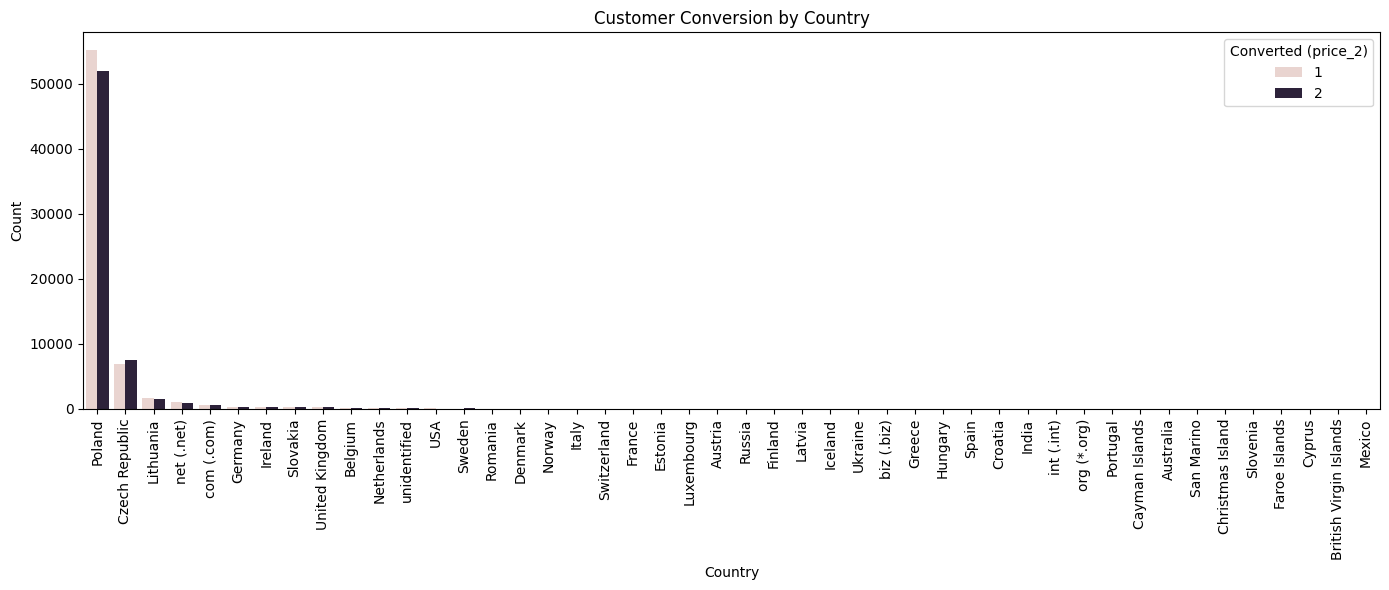

In [18]:
# 1. Visualizations
plt.figure(figsize=(14,6))

sns.countplot(
    data=eda_df,
    x='country',
    hue='price_2',  # seaborn will handle categorical conversion
    order=eda_df['country'].value_counts().index  # order by frequency
)

plt.xticks(rotation=90)
plt.title("Customer Conversion by Country")
plt.xlabel("Country")
plt.ylabel("Count")
plt.legend(title="Converted (price_2)")
plt.tight_layout()
plt.show()


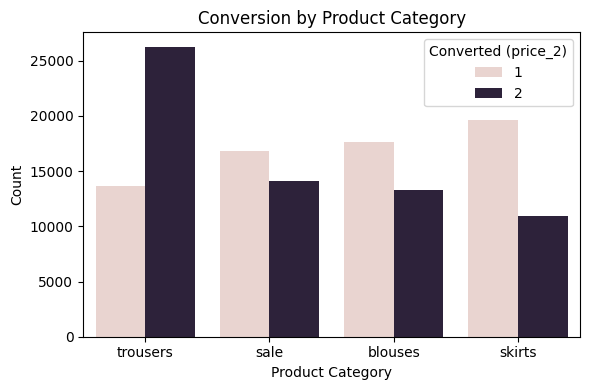

In [19]:
# Conversion by Main Category
plt.figure(figsize=(6,4))

sns.countplot(
    data=eda_df,
    x='page1_main_category',
    hue='price_2',  # seaborn handles categorical conversion
    order=eda_df['page1_main_category'].value_counts().index
)

plt.title("Conversion by Product Category")
plt.xlabel("Product Category")
plt.ylabel("Count")
plt.legend(title="Converted (price_2)")
plt.tight_layout()
plt.show()



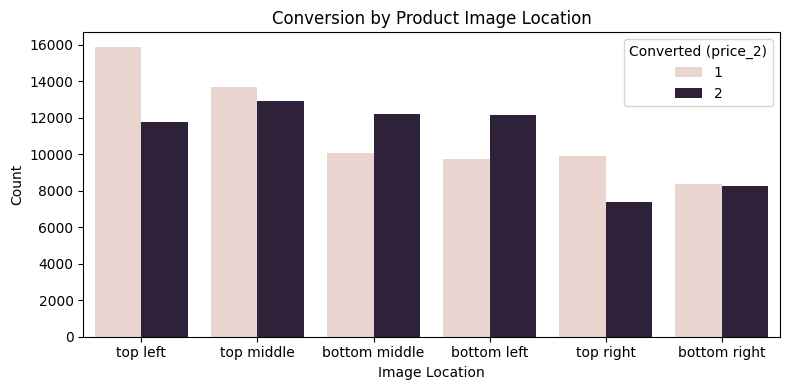

In [20]:
# Conversion by Location
plt.figure(figsize=(8,4))

sns.countplot(
    data=eda_df,
    x='location',
    hue='price_2',  # seaborn handles categorical conversion
    order=eda_df['location'].value_counts().index  # order by frequency
)

plt.title("Conversion by Product Image Location")
plt.xlabel("Image Location")
plt.ylabel("Count")
plt.legend(title="Converted (price_2)")
plt.tight_layout()
plt.show()


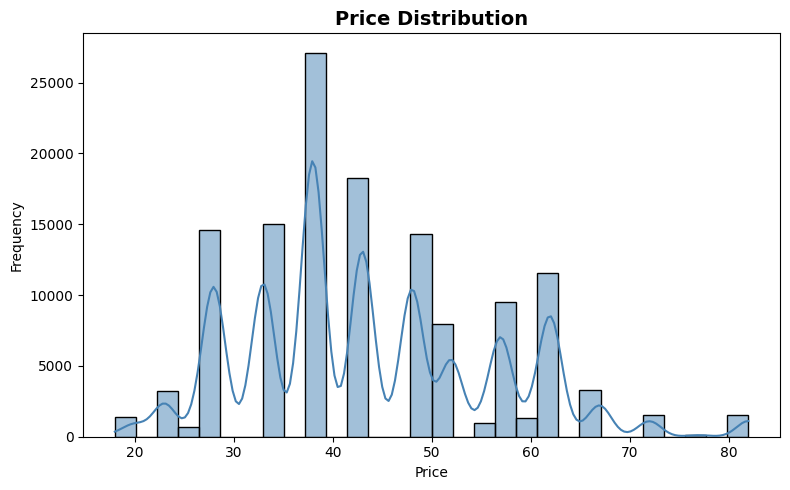

In [21]:
# Histogram: PRICE distribution
plt.figure(figsize=(8,5))

sns.histplot(
    data=eda_df,
    x='price',
    bins=30,
    kde=True,
    color="steelblue",
    edgecolor="black"
)

plt.title("Price Distribution", fontsize=14, fontweight="bold")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


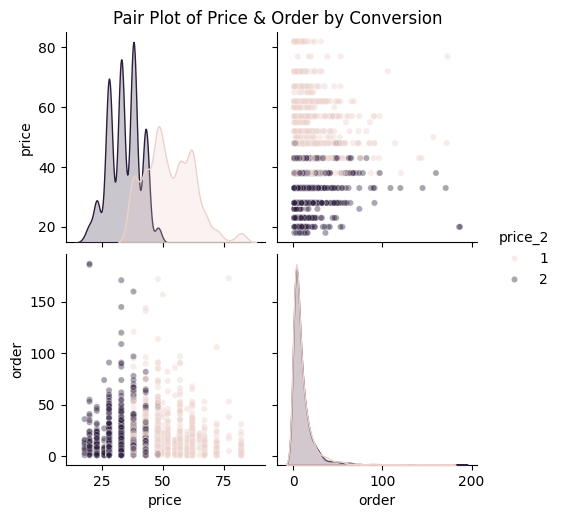

In [22]:
#PairPlots
# Sample for speed and clarity
sample_df = eda_df.sample(n=5000, random_state=42)

num_cols = ['price', 'order']

sns.pairplot(
    sample_df[num_cols + ['price_2']],
    hue='price_2',
    diag_kind='kde',       # KDE on the diagonal instead of hist
    plot_kws={'alpha':0.4, 's':20}  # transparency and point size
)

plt.suptitle("Pair Plot of Price & Order by Conversion", y=1.02)
plt.show()


In [23]:
# 2. Session Analysis
# Session-level features
eda_df['session_length'] = eda_df.groupby('session_id')['order'].transform('max')
eda_df['num_clicks'] = eda_df.groupby('session_id')['order'].transform('count')
eda_df['is_bounce'] = (eda_df['order'] == 1).astype(int)

# Aggregate to one row per session
session_summary = (
    eda_df.groupby('session_id')
          .agg({
              'session_length': 'max',   # longest order index
              'num_clicks': 'max',       # total clicks (already constant per session)
              'is_bounce': 'max'         # bounce flag (0/1 per session)
          })
          .reset_index()
)

print("Session Summary:")
print(session_summary.describe())



Session Summary:
         session_id  session_length    num_clicks     is_bounce
count  22910.000000    22910.000000  22910.000000  22910.000000
mean   12029.363684        6.982366      5.778219      0.841598
std     6941.966183        9.094983      7.324557      0.365126
min        1.000000        1.000000      1.000000      0.000000
25%     6011.500000        2.000000      2.000000      1.000000
50%    12043.500000        4.000000      3.000000      1.000000
75%    18048.500000        9.000000      7.000000      1.000000
max    24026.000000      195.000000    164.000000      1.000000


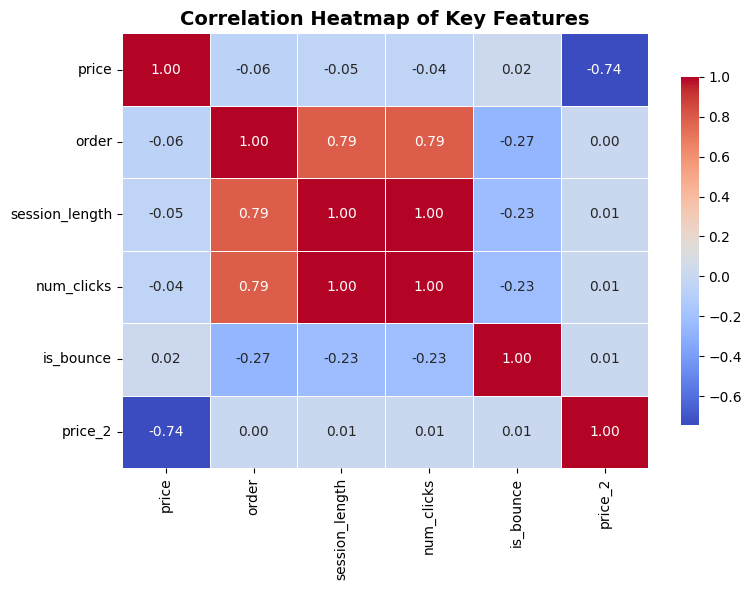

In [24]:
# 3. Correlation Analysis

plt.figure(figsize=(8,6))

num_cols = ['price','order','session_length','num_clicks','is_bounce','price_2']

# Compute correlation matrix
corr_matrix = eda_df[num_cols].apply(pd.to_numeric, errors='coerce').corr()

# Heatmap
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)

plt.title("Correlation Heatmap of Key Features", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()


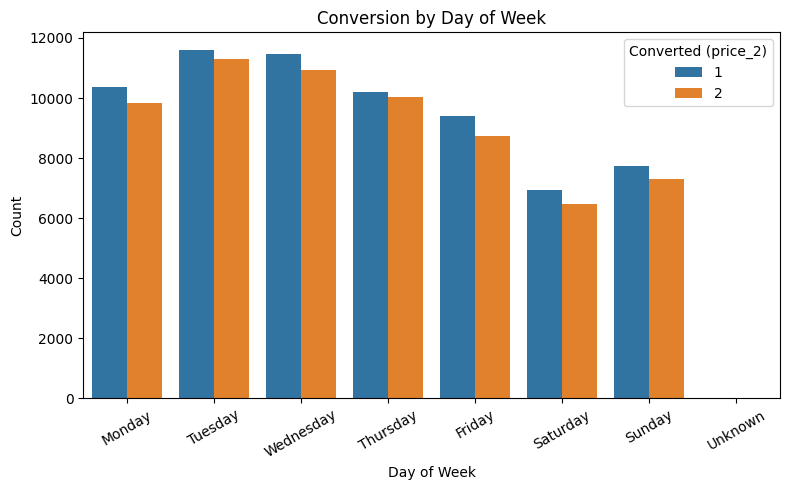

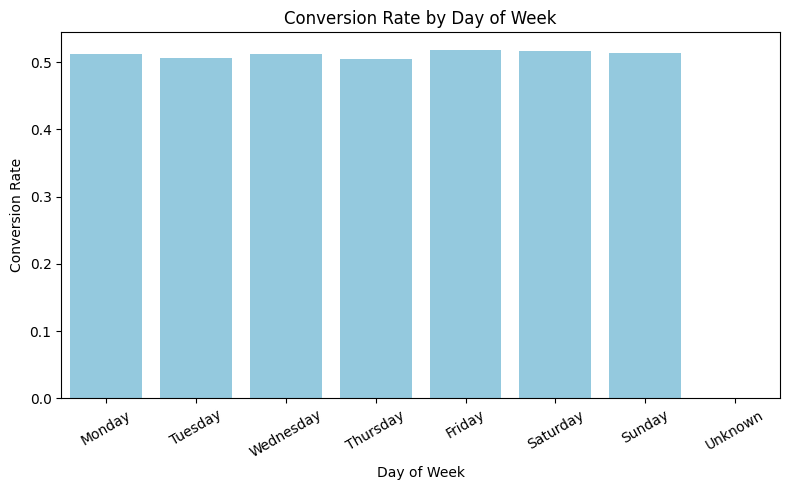

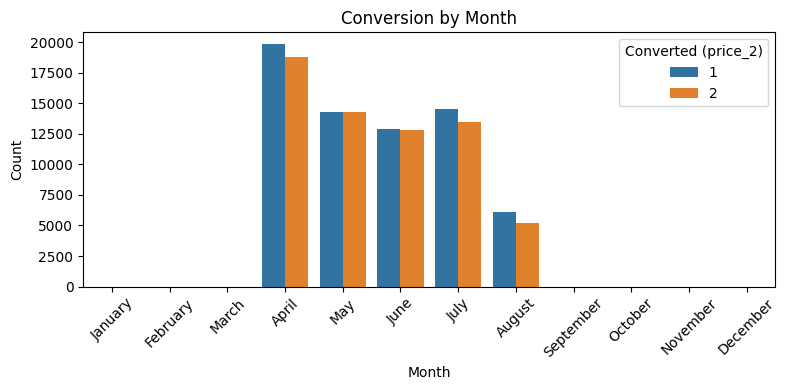

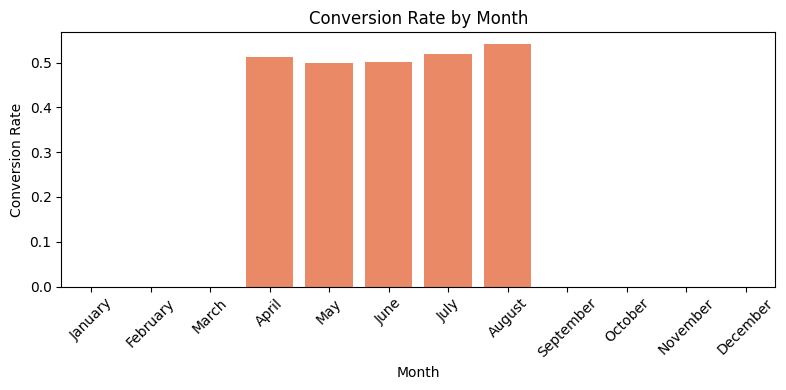

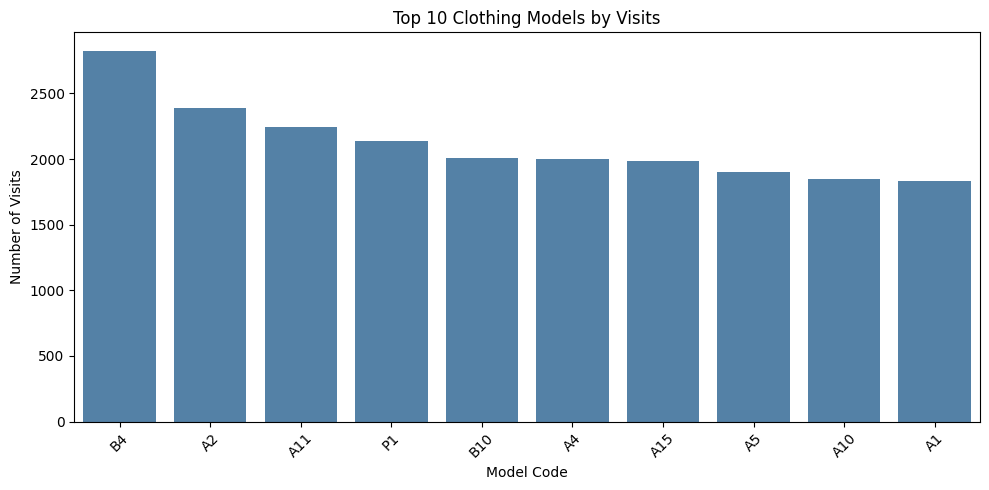

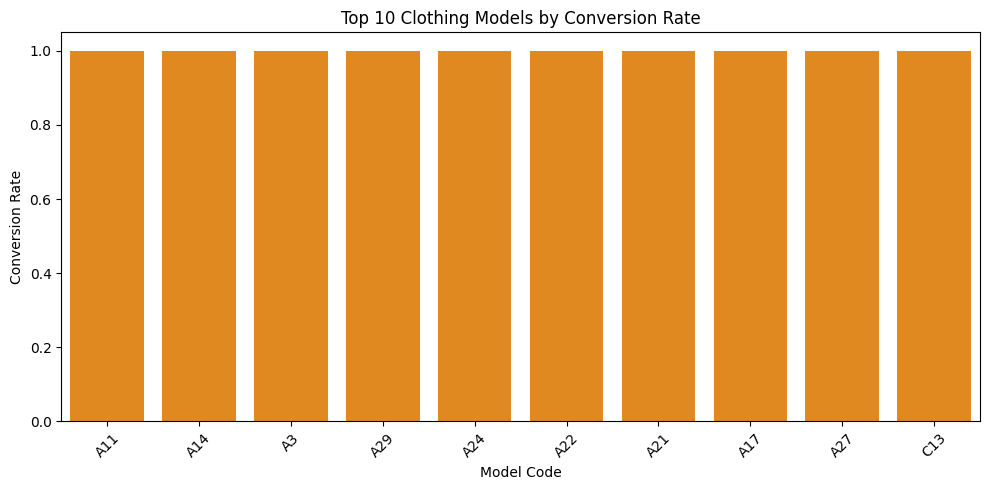

In [25]:
# 4. Time-based Analysis
import calendar

# --- Ensure numeric for date parts ---
eda_df['year'] = pd.to_numeric(eda_df['year'], errors='coerce')
eda_df['month'] = pd.to_numeric(eda_df['month'], errors='coerce')
eda_df['day'] = pd.to_numeric(eda_df['day'], errors='coerce')

# --- Create datetime safely ---
eda_df['date'] = pd.to_datetime(
    eda_df[['year', 'month', 'day']],
    errors='coerce'  # invalid dates become NaT
)

# --- Extract day of week ---
eda_df['day_of_week'] = eda_df['date'].dt.day_name().fillna('Unknown')

# --- Convert target to categorical for plotting ---
eda_df['price_2'] = eda_df['price_2'].astype(str)

# --- Conversion by Day of Week (counts) ---
plt.figure(figsize=(8,5))
sns.countplot(
    data=eda_df,
    x='day_of_week',
    hue='price_2',
    order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday','Unknown']
)
plt.title("Conversion by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Count")
plt.xticks(rotation=30)
plt.legend(title="Converted (price_2)")
plt.tight_layout()
plt.show()

# --- Conversion Rate by Day of Week (rates) ---
conv_by_day = (
    eda_df.groupby('day_of_week')['price_2']
          .apply(lambda x: (x == '1').mean())  # conversion rate
          .reindex(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday','Unknown'])
)

plt.figure(figsize=(8,5))
sns.barplot(x=conv_by_day.index, y=conv_by_day.values, color="skyblue")
plt.title("Conversion Rate by Day of Week")
plt.ylabel("Conversion Rate")
plt.xlabel("Day of Week")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

# --- Conversion by Month (counts) ---
month_order = list(range(1,13))
month_labels = [calendar.month_name[m] for m in month_order]

plt.figure(figsize=(8,4))
sns.countplot(
    data=eda_df,
    x='month',
    hue='price_2',
    order=month_order
)
plt.xticks(ticks=range(len(month_labels)), labels=month_labels, rotation=45)
plt.title("Conversion by Month")
plt.xlabel("Month")
plt.ylabel("Count")
plt.legend(title="Converted (price_2)")
plt.tight_layout()
plt.show()

# --- Conversion Rate by Month (rates) ---
conv_by_month = (
    eda_df.groupby('month')['price_2']
          .apply(lambda x: (x == '1').mean())
          .reindex(month_order)
)

plt.figure(figsize=(8,4))
sns.barplot(x=month_labels, y=conv_by_month.values, color="coral")
plt.title("Conversion Rate by Month")
plt.xlabel("Month")
plt.ylabel("Conversion Rate")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- Top 10 Clothing Models by Visits ---
top_models = eda_df['page2_clothing_model'].value_counts().head(10)

plt.figure(figsize=(10,5))
sns.barplot(
    x=top_models.index,
    y=top_models.values,
    order=top_models.index,
    color="steelblue"
)
plt.title("Top 10 Clothing Models by Visits")
plt.xlabel("Model Code")
plt.ylabel("Number of Visits")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- Top 10 Clothing Models by Conversion Rate ---
conv_by_model = (
    eda_df.groupby('page2_clothing_model')['price_2']
          .apply(lambda x: (x == '1').mean())
          .sort_values(ascending=False)
          .head(10)
)

plt.figure(figsize=(10,5))
sns.barplot(
    x=conv_by_model.index,
    y=conv_by_model.values,
    color="darkorange"
)
plt.title("Top 10 Clothing Models by Conversion Rate")
plt.xlabel("Model Code")
plt.ylabel("Conversion Rate")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# **4. Classification Pipeline with Smote**

Dropping 219 columns (leakage/overfit control):
['order', 'page', 'page2_clothing_model_A1', 'page2_clothing_model_A10', 'page2_clothing_model_A11', 'page2_clothing_model_A12', 'page2_clothing_model_A13', 'page2_clothing_model_A14', 'page2_clothing_model_A15', 'page2_clothing_model_A16', 'page2_clothing_model_A17', 'page2_clothing_model_A18', 'page2_clothing_model_A19', 'page2_clothing_model_A2', 'page2_clothing_model_A20', 'page2_clothing_model_A21', 'page2_clothing_model_A22', 'page2_clothing_model_A23', 'page2_clothing_model_A24', 'page2_clothing_model_A25'] ...
Target distribution BEFORE SMOTE:
Counter({0: 67714, 1: 64665})


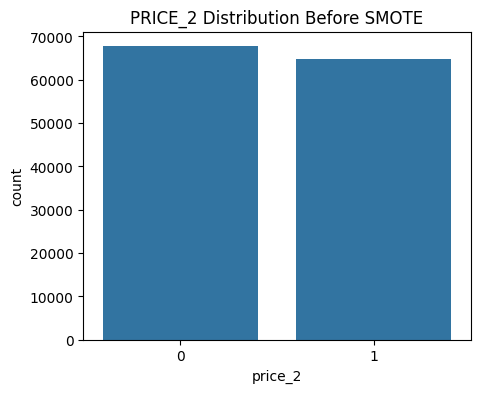


Target distribution AFTER SMOTE (Training Set):
Counter({0: 54171, 1: 54171})


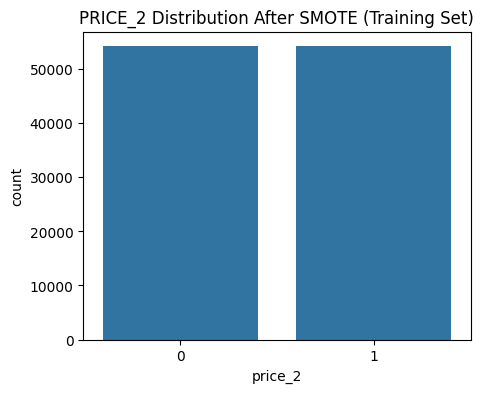


Training LogisticRegression...

Training DecisionTree...
Best params for DecisionTree: {'model__max_depth': 10, 'model__min_samples_split': 5}

Training RandomForest...
Best params for RandomForest: {'model__max_depth': None, 'model__n_estimators': 200}

Training XGBoost...
Best params for XGBoost: {'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 200}

Training NeuralNetwork...
Best params for NeuralNetwork: {'model__activation': 'relu', 'model__hidden_layer_sizes': (50, 50)}

Classification Results:
                     Accuracy  Precision    Recall  F1-Score
NeuralNetwork       0.883593   0.883807  0.883593  0.883534
XGBoost             0.880496   0.880624  0.880496  0.880450
DecisionTree        0.875963   0.875960  0.875963  0.875961
RandomForest        0.873659   0.873659  0.873659  0.873646
LogisticRegression  0.572783   0.573565  0.572783  0.572723

Best overall model: NeuralNetwork (Accuracy=0.884)

Confusion Matrix:
 [[12183  1360]
 [ 1722 11211]]


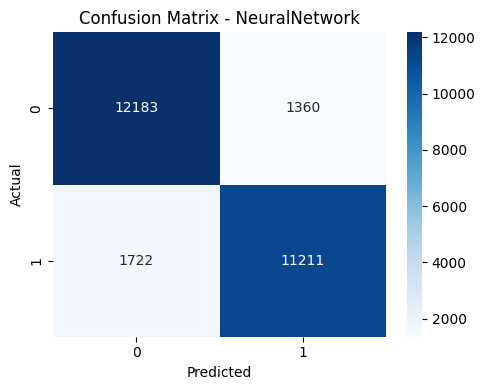


Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.90      0.89     13543
           1       0.89      0.87      0.88     12933

    accuracy                           0.88     26476
   macro avg       0.88      0.88      0.88     26476
weighted avg       0.88      0.88      0.88     26476



In [11]:
from collections import Counter
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
import cloudpickle
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# --- 0) Map target to 0/1 ---
y_class_mapped = y_class.map({1: 0, 2: 1})

# --- 1) Leakage audit & pruning on X_class ---
Xc = X_class.copy()

# 1a) Drop columns with zero variance
zero_var = Xc.columns[Xc.nunique() <= 1].tolist()

# 1b) Drop features perfectly aligned with target (mean per class is 0 or 1)
tmp = Xc.copy()
tmp['__target__'] = y_class_mapped.values
means_by_class = tmp.groupby('__target__').mean().T
perfect_leak = means_by_class[(means_by_class[0].isin([0.0,1.0])) | (means_by_class[1].isin([0.0,1.0]))].index.tolist()

# 1c) Proactively drop high-leakage behavioral columns if present
# 'order' often encodes post-conversion position; 'page' can encode funnel endpoints
behavioral_drop = [c for c in ['order','page'] if c in Xc.columns]

# 1d) Limit overfit from high-cardinality clothing model dummies: keep only top-N by prevalence
model_cols = [c for c in Xc.columns if c.startswith('page2_clothing_model_')]
keep_n_models = 50  # adjust if needed
drop_model_cols = []
if model_cols:
    prevalences = Xc[model_cols].mean().sort_values(ascending=False)
    keep_models = set(prevalences.head(keep_n_models).index)
    drop_model_cols = [c for c in model_cols if c not in keep_models]

# 1e) Apply drops
to_drop = sorted(set(zero_var) | set(perfect_leak) | set(behavioral_drop) | set(drop_model_cols))
if to_drop:
    print(f"Dropping {len(to_drop)} columns (leakage/overfit control):")
    print(to_drop[:20], "..." if len(to_drop) > 20 else "")
    Xc = Xc.drop(columns=to_drop)

# --- 2) Target distribution BEFORE SMOTE ---
print("Target distribution BEFORE SMOTE:")
print(Counter(y_class_mapped))

plt.figure(figsize=(5,4))
sns.countplot(x=y_class_mapped.astype(str))
plt.title("PRICE_2 Distribution Before SMOTE")
plt.show()

# --- 3) Train/validation split (stratified) ---
Xc_train, Xc_val, yc_train, yc_val = train_test_split(
    Xc, y_class_mapped, test_size=0.2, random_state=42, stratify=y_class_mapped
)

# --- 4) Apply SMOTE once on training set for visualization only ---
smote_vis = SMOTE(random_state=42)
_, yc_train_res = smote_vis.fit_resample(Xc_train, yc_train)

print("\nTarget distribution AFTER SMOTE (Training Set):")
print(Counter(yc_train_res))

plt.figure(figsize=(5,4))
sns.countplot(x=yc_train_res.astype(str))
plt.title("PRICE_2 Distribution After SMOTE (Training Set)")
plt.show()

# --- 5) Define models ---
models = {
    'LogisticRegression': LogisticRegression(max_iter=500, class_weight='balanced', random_state=42),
    'DecisionTree': DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    'RandomForest': RandomForestClassifier(random_state=42, class_weight='balanced'),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'NeuralNetwork': MLPClassifier(max_iter=500, random_state=42)
}

# --- 6) Hyperparameter grids ---
params = {
    'DecisionTree': {'model__max_depth':[5,10,None],'model__min_samples_split':[2,5]},
    'RandomForest': {'model__n_estimators':[100,200],'model__max_depth':[5,10,None]},
    'XGBoost': {'model__n_estimators':[100,200],'model__max_depth':[3,5],'model__learning_rate':[0.01,0.1]},
    'NeuralNetwork': {'model__hidden_layer_sizes':[(50,50),(100,)], 'model__activation':['relu','tanh']}
}

# --- 7) Train with pipeline: SMOTE -> SelectKBest(MI) -> Scale -> Model ---
# Feature selection inside the pipeline avoids peeking and reduces overfit.
results = {}
best_overall_model = None
best_overall_score = 0
best_overall_name = None

for name, model in models.items():
    print(f"\nTraining {name}...")
    pipeline = ImbPipeline([
        ('smote', SMOTE(random_state=42)),
        ('select', SelectKBest(mutual_info_classif, k=min(100, Xc_train.shape[1]))),  # cap features
        ('scaler', StandardScaler()),
        ('model', model)
    ])

    if name in params:
        grid = GridSearchCV(pipeline, params[name], cv=3, scoring='accuracy', n_jobs=-1)
        grid.fit(Xc_train, yc_train)
        best_model = grid.best_estimator_
        print(f"Best params for {name}: {grid.best_params_}")
    else:
        pipeline.fit(Xc_train, yc_train)
        best_model = pipeline

    y_pred = best_model.predict(Xc_val)

    acc = accuracy_score(yc_val, y_pred)
    results[name] = {
        'Accuracy': acc,
        'Precision': precision_score(yc_val, y_pred, average='weighted', zero_division=0),
        'Recall': recall_score(yc_val, y_pred, average='weighted'),
        'F1-Score': f1_score(yc_val, y_pred, average='weighted')
    }

    if acc > best_overall_score:
        best_overall_score = acc
        best_overall_model = best_model
        best_overall_name = name

# --- 8) Results summary ---
results_df = pd.DataFrame(results).T.sort_values('Accuracy', ascending=False)
print("\nClassification Results:\n", results_df)
print(f"\nBest overall model: {best_overall_name} (Accuracy={best_overall_score:.3f})")

# --- 9) Confusion Matrix & Classification Report for best model ---
y_best_pred = best_overall_model.predict(Xc_val)

cm = confusion_matrix(yc_val, y_best_pred)
print("\nConfusion Matrix:\n", cm)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix - {best_overall_name}")
plt.tight_layout()
plt.show()

print("\nClassification Report:\n")
print(classification_report(yc_val, y_best_pred, zero_division=0))

# --- 10) Save best model ---
with open("best_classifier.pkl","wb") as f:
    cloudpickle.dump(best_overall_model, f)


# **5. Regression Pipeline**

In [17]:
# Feature hygiene (mirror classification)

Xr = X_reg.copy()
yr = y_reg.copy()

# Drop zero-variance columns
zero_var = Xr.columns[Xr.nunique() <= 1].tolist()

# Drop high-leakage funnel columns if present
behavioral_drop = [c for c in ['order', 'page'] if c in Xr.columns]

# Limit high-cardinality clothing model dummies
model_cols = [c for c in Xr.columns if c.startswith('page2_clothing_model_')]
keep_n_models = 50
drop_model_cols = []
if model_cols:
    prevalences = Xr[model_cols].mean().sort_values(ascending=False)
    keep_models = set(prevalences.head(keep_n_models).index)
    drop_model_cols = [c for c in model_cols if c not in keep_models]

to_drop = sorted(set(zero_var) | set(behavioral_drop) | set(drop_model_cols))
if to_drop:
    print(f"Dropping {len(to_drop)} columns (regression hygiene):")
    print(to_drop[:20], "..." if len(to_drop) > 20 else "")
    Xr = Xr.drop(columns=to_drop)


# 1) Define regressors

regressors = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0, random_state=42),
    "Lasso": Lasso(alpha=0.01, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
}


# 2) Train/validation split

X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(
    Xr, yr, test_size=0.2, random_state=42
)


# 3) Hyperparameter grids

param_grids = {
    "Ridge": {"model__alpha": [0.1, 1.0, 10.0]},
    "Lasso": {"model__alpha": [0.001, 0.01, 0.1]},
    "GradientBoosting": {
        "model__n_estimators": [100, 200],
        "model__max_depth": [2, 3],
        "model__learning_rate": [0.05, 0.1]
    }
}


# 4) Train and evaluate models

regression_results = {}
best_model = None
best_score = -np.inf
best_name = None

for name, model in regressors.items():
    print(f"\nTraining {name}...")
    pipeline = ImbPipeline([
        ("select", SelectKBest(f_regression, k=min(100, X_reg_train.shape[1]))),
        ("scaler", StandardScaler()),
        ("model", model)
    ])

    if name in param_grids:
        grid = GridSearchCV(
            pipeline, param_grids[name],
            cv=3, scoring="r2", n_jobs=-1
        )
        grid.fit(X_reg_train, y_reg_train)
        pipe = grid.best_estimator_
        print(f"Best params for {name}: {grid.best_params_}")
    else:
        pipe = pipeline.fit(X_reg_train, y_reg_train)

    y_pred = pipe.predict(X_reg_test)
    mae = mean_absolute_error(y_reg_test, y_pred)
    mse = mean_squared_error(y_reg_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_reg_test, y_pred)

    regression_results[name] = {"MAE": mae, "MSE": mse, "RMSE": rmse, "R2": r2}

    if r2 > best_score:
        best_score = r2
        best_model = pipe
        best_name = name


# 5) Results summary

results_df = pd.DataFrame(regression_results).T.sort_values("R2", ascending=False)
print("\nRegression Results:\n", results_df)
print(f"\nBest overall regressor: {best_name} (R²={best_score:.3f})")


# 6) Refit best model on full dataset and save

best_model.fit(Xr, yr)

with open("best_regressor.pkl", "wb") as f:
    cloudpickle.dump(best_model, f)

Dropping 169 columns (regression hygiene):
['order', 'page', 'page2_clothing_model_A14', 'page2_clothing_model_A18', 'page2_clothing_model_A19', 'page2_clothing_model_A20', 'page2_clothing_model_A22', 'page2_clothing_model_A23', 'page2_clothing_model_A24', 'page2_clothing_model_A25', 'page2_clothing_model_A26', 'page2_clothing_model_A27', 'page2_clothing_model_A28', 'page2_clothing_model_A29', 'page2_clothing_model_A30', 'page2_clothing_model_A32', 'page2_clothing_model_A33', 'page2_clothing_model_A34', 'page2_clothing_model_A35', 'page2_clothing_model_A36'] ...

Training LinearRegression...

Training Ridge...
Best params for Ridge: {'model__alpha': 10.0}

Training Lasso...
Best params for Lasso: {'model__alpha': 0.001}

Training GradientBoosting...
Best params for GradientBoosting: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 200}

Regression Results:
                        MAE        MSE      RMSE        R2
GradientBoosting  4.943945  45.586137  6.7517

# **6.Clustering Pipeline**

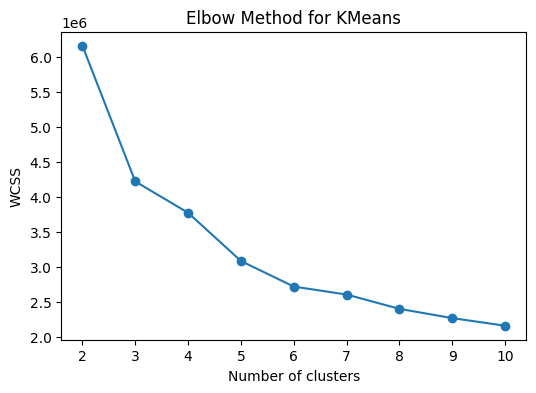

KMeans Silhouette Score: 0.24078269228156937
KMeans Davies-Bouldin Index: 1.1601523250074153


In [18]:
# --- Sample data to reduce memory ---
X_clu_sample = X_clu.sample(n=min(10000, len(X_clu)), random_state=42)

# --- Elbow method for KMeans ---
wcss = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_clu_sample)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(6,4))
plt.plot(range(2, 11), wcss, marker='o')
plt.title("Elbow Method for KMeans")
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.show()

# --- Fit final KMeans with chosen k ---
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(X_clu_sample)

# --- Cluster quality metrics ---
print("KMeans Silhouette Score:", silhouette_score(X_clu_sample, kmeans_labels))
print("KMeans Davies-Bouldin Index:", davies_bouldin_score(X_clu_sample, kmeans_labels))

In [19]:
# --- DBSCAN ---
dbscan = DBSCAN(eps=2, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_clu_sample)

# Mask out noise points (-1)
mask = dbscan_labels != -1

# Check if DBSCAN found at least 2 clusters (excluding noise)
if np.sum(mask) > 1 and len(set(dbscan_labels[mask])) > 1:
    print("DBSCAN Silhouette Score:", silhouette_score(X_clu_sample.iloc[mask], dbscan_labels[mask]))
    print("DBSCAN Davies-Bouldin Index:", davies_bouldin_score(X_clu_sample.iloc[mask], dbscan_labels[mask]))
else:
    print("DBSCAN: Not enough clusters for silhouette score")

DBSCAN Silhouette Score: 0.4922098245578977
DBSCAN Davies-Bouldin Index: 0.7916940219557349


In [20]:
# --- Sample data to reduce memory usage ---
sample_size = min(10000, len(X_clu))  # avoid oversampling
X_clu_sample = X_clu.sample(n=sample_size, random_state=42)

# --- Optional: Reduce dimensionality with PCA ---
pca = PCA(n_components=10, random_state=42)
X_clu_reduced = pca.fit_transform(X_clu_sample)

# --- Agglomerative Clustering ---
agglo = AgglomerativeClustering(n_clusters=7)
agglo_labels = agglo.fit_predict(X_clu_reduced)

# --- Cluster Evaluation ---
if len(set(agglo_labels)) > 1:  # ensure more than one cluster
    sil_score = silhouette_score(X_clu_reduced, agglo_labels)
    db_score = davies_bouldin_score(X_clu_reduced, agglo_labels)
    print("Agglomerative Silhouette Score:", sil_score)
    print("Agglomerative Davies-Bouldin Index:", db_score)
else:
    print("Agglomerative: Only one cluster found, cannot compute silhouette/DBI")

Agglomerative Silhouette Score: 0.18322965411596415
Agglomerative Davies-Bouldin Index: 1.169384068952984


In [21]:
with open("dbscan_model.pkl", "wb") as f:
    cloudpickle.dump(dbscan, f)